# Predicción de ventas

Los datos entregados corresponden a ventas realizadas en una única tienda Jumbo en el período que comprende desde el 2021-01-02 hasta el 2022-01-09. El objetivo final de la evaluación es realizar una predicción diaria de las ventas de la semana del 17 al 23 de Enero del 2022, es decir, un valor para cada día de la semana y para cada producto (Notar el desfase de una semana entre los datos y el período deseado). Los resultados numéricos concretos de dicha predicción no son relevantes para la evaluación, si no más bien el desarrollo y su dominio que quedará reflejado en el trabajo.

El dataset está compuesto por:


column_name | name      | description
------------|-----------|-------------------------------------------------------
ds          | fecha     | En formato YYYY-MM-DD, corresponde a la fecha de la transacción.
item_id     | producto_id | Identificador del producto que se vendió.
y           | venta     | Cantidad vendida del producto. En caso de ser decimal, se vende a granel (por ejemplo, frutas).
hierarchy_2_code | rubro_id | Código correspondiente al rubro al que pertenece el producto.


En el análisis exploratiorio y de limpieza de los datos separemos el dataset en train y test y luego realizamos la limpieza en el dataset de train. Este es el que vamos a utilizar para realizar las predicciones pero antes introduciremos algunos conceptos a tener en cuenta a la hora de trabajar con series de tiempo.

In [1]:
# !pip install prophet

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime

from prophet import Prophet

import joblib

sns.set(font_scale=1.2)

## Importamos el Dataset

In [3]:
# Importamos el dataset de train con la limpieza realizada en el análisis exploratiorio
ventas = pd.read_csv('datos_ventas_train_sample.csv',
                           sep=',')
ventas.head()

,ds,hierarchy_2_code,item_id,y
0,2021-01-02,60,937937,15.0
1,2021-01-02,82,955764,6.0
2,2021-01-02,101,3935,0.0
3,2021-01-02,15,1403,241.0
4,2021-01-02,82,1138428,0.0


In [4]:
# Importamos el dataset de test
validation = pd.read_csv('datos_ventas_validation_sample.csv',
                           sep=',')
validation.head()

,ds,hierarchy_2_code,item_id,y
0,2022-01-03,101,3906,4.0
1,2022-01-03,60,937937,25.0
2,2022-01-03,82,955764,5.0
3,2022-01-03,15,376635,10.0
4,2022-01-03,71,440500,19.0


In [5]:
df_train = ventas.copy()
df_val = validation.copy()

In [6]:
print(df_train.info(),
      df_val.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5490 entries, 0 to 5489
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ds                5490 non-null   object 
 1   hierarchy_2_code  5490 non-null   int64  
 2   item_id           5490 non-null   int64  
 3   y                 5490 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 171.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ds                105 non-null    object 
 1   hierarchy_2_code  105 non-null    int64  
 2   item_id           105 non-null    int64  
 3   y                 105 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 3.4+ KB
None None


In [7]:
# Convertimos ds a datetime y los items y rubros a object
df_train['ds'] = pd.to_datetime(df_train['ds'])
df_train[['item_id', 'hierarchy_2_code']] = df_train[['item_id', 'hierarchy_2_code']].astype('object')
df_train.fillna(0, inplace=True)

df_val['ds'] = pd.to_datetime(df_val['ds'])
df_val[['item_id', 'hierarchy_2_code']] = df_val[['item_id', 'hierarchy_2_code']].astype('object')
df_val.fillna(0, inplace=True)

In [8]:
# Chequeamos cuántos items tenemos en el dataset de train
df_train.nunique()

ds                  366
hierarchy_2_code      9
item_id              15
y                   384
dtype: int64

In [9]:
df_val.nunique()

ds                   7
hierarchy_2_code     9
item_id             15
y                   44
dtype: int64

### Ajuste de Modelo Prophet

Prophet es una biblioteca de código abierto desarrollada por Facebook para el pronóstico de series temporales. Utiliza un enfoque aditivo que modela tendencias no lineales con componentes estacionales y efectos de días festivos. El algoritmo subyacente se basa en un modelo de regresión con funciones de base suave que capturan las tendencias y patrones estacionales en los datos.

Lo destacado de Prophet es su capacidad para manejar automáticamente valores atípicos y datos faltantes. Utiliza técnicas de imputación y modelado robusto para minimizar el impacto de estas anomalías en las predicciones. Esto es especialmente relevante para nuestros datos, ya que la presencia de valores atípicos y faltantes puede afectar la precisión de los pronósticos. Por ejemplo no hemos excluido los días festivos que no tienen ventas.

Prophet también ofrece la flexibilidad de incluir covariables, lo que permite modelar factores externos que pueden influir en la serie temporal objetivo. Esto proporciona una forma más completa de capturar las relaciones y los efectos de variables adicionales en nuestras predicciones.

En este caso agregaremos el indicador de si es fin de semana o no a modo ilustrativo, podríamos agregar el día de la semana convirtiendolo luego en dummy u otras variables con mayor información, en caso de tenerla.

In [10]:
# Métricas que vamos a utlizar para evaluar los resultados
def prediction_mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))

def prediction_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_pred - y_true)**2))

In [11]:
# # Agregamos un nuevo feature, si es fin de semana o no.
# df_train['fin_de_semana'] = np.where(df_train['ds'].dt.dayofweek.isin([5, 6]), 1, 0)
# df_val['fin_de_semana'] = np.where(df_val['ds'].dt.dayofweek.isin([5, 6]), 1, 0)
# df_val.head()

Comenzamos importando Prophet y creando una lista p para almacenar las predicciones.

Luego tenemos un ciclo que itera sobre los valores únicos de la columna de la familia en el conjunto de datos del tren para crear un pronóstico separado para cada serie. A continuación, el código crea dos nuevos conjuntos de datos, train_ y valid_, que contienen solo las filas de los conjuntos de datos de entrenamiento y validación originales que corresponden a la familia actual que se pronostica.

- El modo de estacionalidad está configurado en aditivo de forma predeterminada, pero podría configurarse en multiplicativo. Este parámetro controla cómo se modelan los componentes estacionales.
- *yearly_seasonality* corresponde a la estacionalidad durante todo el año. Se puede utilizar para capturar la estacionalidad de regreso a la escuela, la estacionalidad de las vacaciones de verano, y así sucesivamente.

- *weekly_seasonality* modela patrones que se repiten a lo largo de la semana. Se puede utilizar para capturar patrones como que los fines de semana están más ocupados que los días laborables.

- *daily_seasonality* modela patrones que se repiten a lo largo del día. Se puede usar para capturar patrones como que la hora del almuerzo está más ocupada que la hora de la cena.

- La función add_regressor se utiliza para agregar columnas adicionales al modelo. Se puede usar esta función para agregar tantas variables externas como queramos.

- La función de ajuste entrena el modelo usando los datos de entrenamiento.

In [12]:
# Definimos el dataframe para guardar las predicciones y los errores
df_predictions = []
pred_mae = []
pred_rmse = []


for item_id in df_train['item_id'].unique():
    
    df_train_ = df_train.loc[df_train['item_id'] == item_id]
    df_val_ = df_val.loc[df_val['item_id'] == item_id]
    df_val_.reset_index(inplace=True)
    
    model = Prophet(seasonality_mode='additive', yearly_seasonality=True, 
                weekly_seasonality=True, daily_seasonality=False)
#     m.add_regressor('fin_de_semana')
    model.fit(df_train_)
    
    # Prediciones en el dataset de val
    future = model.make_future_dataframe(periods=7, include_history=False)
    future = future.merge(df_val_[['ds'
#                                    , 'fin_de_semana'
                                  ]], on='ds', how='left')
    forecast = model.predict(future)
    forecast['item_id'] = item_id
    
    df_predictions.append(forecast[['ds', 'yhat', 'yhat_lower', 
                                'yhat_upper', 'item_id']])
    
    # Evaluamos el error de predicción de cada item
    e_mae = prediction_mae(df_val_['y'], forecast['yhat'])
    e_rmse = prediction_rmse(df_val_['y'], forecast['yhat'])
    pred_rmse.append(e_rmse)
    pred_mae.append(e_mae)
    print('item_id:', item_id, 'rmse:', e_rmse, 'mae:', e_mae)
    
    # Guardamos cada uno de nuestros modelos en una carpeta, indicando el item_id
    joblib.dump(model, f'Prophet/prophet_{item_id}.pkl')

# Dataset con las predicciones    
df_predictions = pd.concat(df_predictions, ignore_index=True)
df_predictions['yhat'] = df_predictions['yhat'].clip(lower=0)
df_predictions = df_predictions.merge(df_val, on=['ds', 'item_id'], how='left')


pred_errors = {'item_id': df_train['item_id'].unique(),
               'pred_mae': pred_mae,
               'pred_rmse': pred_rmse}
pred_errors = pd.DataFrame(pred_errors)

17:42:14 - cmdstanpy - INFO - Chain [1] start processing
17:42:14 - cmdstanpy - INFO - Chain [1] done processing
17:42:14 - cmdstanpy - INFO - Chain [1] start processing
17:42:14 - cmdstanpy - INFO - Chain [1] done processing
17:42:14 - cmdstanpy - INFO - Chain [1] start processing


item_id: 937937 rmse: 6.397289563135592 mae: 4.57494913079802
item_id: 955764 rmse: 3.3141535502704804 mae: 2.8401949163509976


17:42:14 - cmdstanpy - INFO - Chain [1] done processing
17:42:14 - cmdstanpy - INFO - Chain [1] start processing
17:42:14 - cmdstanpy - INFO - Chain [1] done processing
17:42:15 - cmdstanpy - INFO - Chain [1] start processing


item_id: 3935 rmse: 1.168217989845903 mae: 0.7906716552182002
item_id: 1403 rmse: 163.18126617075816 mae: 152.62818619795635


17:42:15 - cmdstanpy - INFO - Chain [1] done processing
17:42:15 - cmdstanpy - INFO - Chain [1] start processing
17:42:15 - cmdstanpy - INFO - Chain [1] done processing
17:42:15 - cmdstanpy - INFO - Chain [1] start processing


item_id: 1138428 rmse: 1.3940499120388414 mae: 1.2786372250364992
item_id: 3906 rmse: 1.3222653262768331 mae: 0.9122315529811887


17:42:15 - cmdstanpy - INFO - Chain [1] done processing
17:42:15 - cmdstanpy - INFO - Chain [1] start processing
17:42:15 - cmdstanpy - INFO - Chain [1] done processing
17:42:15 - cmdstanpy - INFO - Chain [1] start processing


item_id: 945593 rmse: 1.479727874822656 mae: 1.37119253305111
item_id: 1078620 rmse: 1.0571769615322224 mae: 0.9549805018038617


17:42:15 - cmdstanpy - INFO - Chain [1] done processing
17:42:15 - cmdstanpy - INFO - Chain [1] start processing
17:42:15 - cmdstanpy - INFO - Chain [1] done processing
17:42:15 - cmdstanpy - INFO - Chain [1] start processing


item_id: 17269 rmse: 2.050945680429199 mae: 1.4006627493624084
item_id: 971991 rmse: 37.52045426486602 mae: 35.84636030549842


17:42:15 - cmdstanpy - INFO - Chain [1] done processing
17:42:15 - cmdstanpy - INFO - Chain [1] start processing
17:42:15 - cmdstanpy - INFO - Chain [1] done processing
17:42:16 - cmdstanpy - INFO - Chain [1] start processing


item_id: 977410 rmse: 15.113807363450237 mae: 12.922613921422824
item_id: 440500 rmse: 32.91140756642445 mae: 29.808620598831542


17:42:16 - cmdstanpy - INFO - Chain [1] done processing
17:42:16 - cmdstanpy - INFO - Chain [1] start processing
17:42:16 - cmdstanpy - INFO - Chain [1] done processing
17:42:16 - cmdstanpy - INFO - Chain [1] start processing


item_id: 494937 rmse: 4.0828227725897035 mae: 3.4161996438973157
item_id: 1394 rmse: 10.395128655587992 mae: 8.359292971277618


17:42:16 - cmdstanpy - INFO - Chain [1] done processing


item_id: 376635 rmse: 3.9928936857907606 mae: 3.6787269639455715


Una vez que hemos realizado el ajuste del pronóstico para cada una de las series, es importante visualizar las predicciones obtenidas. Esto nos permitirá tener una mejor comprensión de cómo se comportan los diferentes items a lo largo del tiempo y evaluar la calidad de las estimaciones realizadas por el modelo de pronóstico. Al visualizar las predicciones, podemos identificar patrones, tendencias, estacionalidad u otros comportamientos relevantes en los datos. Además, nos brinda la oportunidad de comparar las predicciones con los valores reales y evaluar la precisión del modelo. Esta visualización nos ayuda a tomar decisiones informadas y ajustar nuestros enfoques de pronóstico en función de las características y particularidades de cada item.

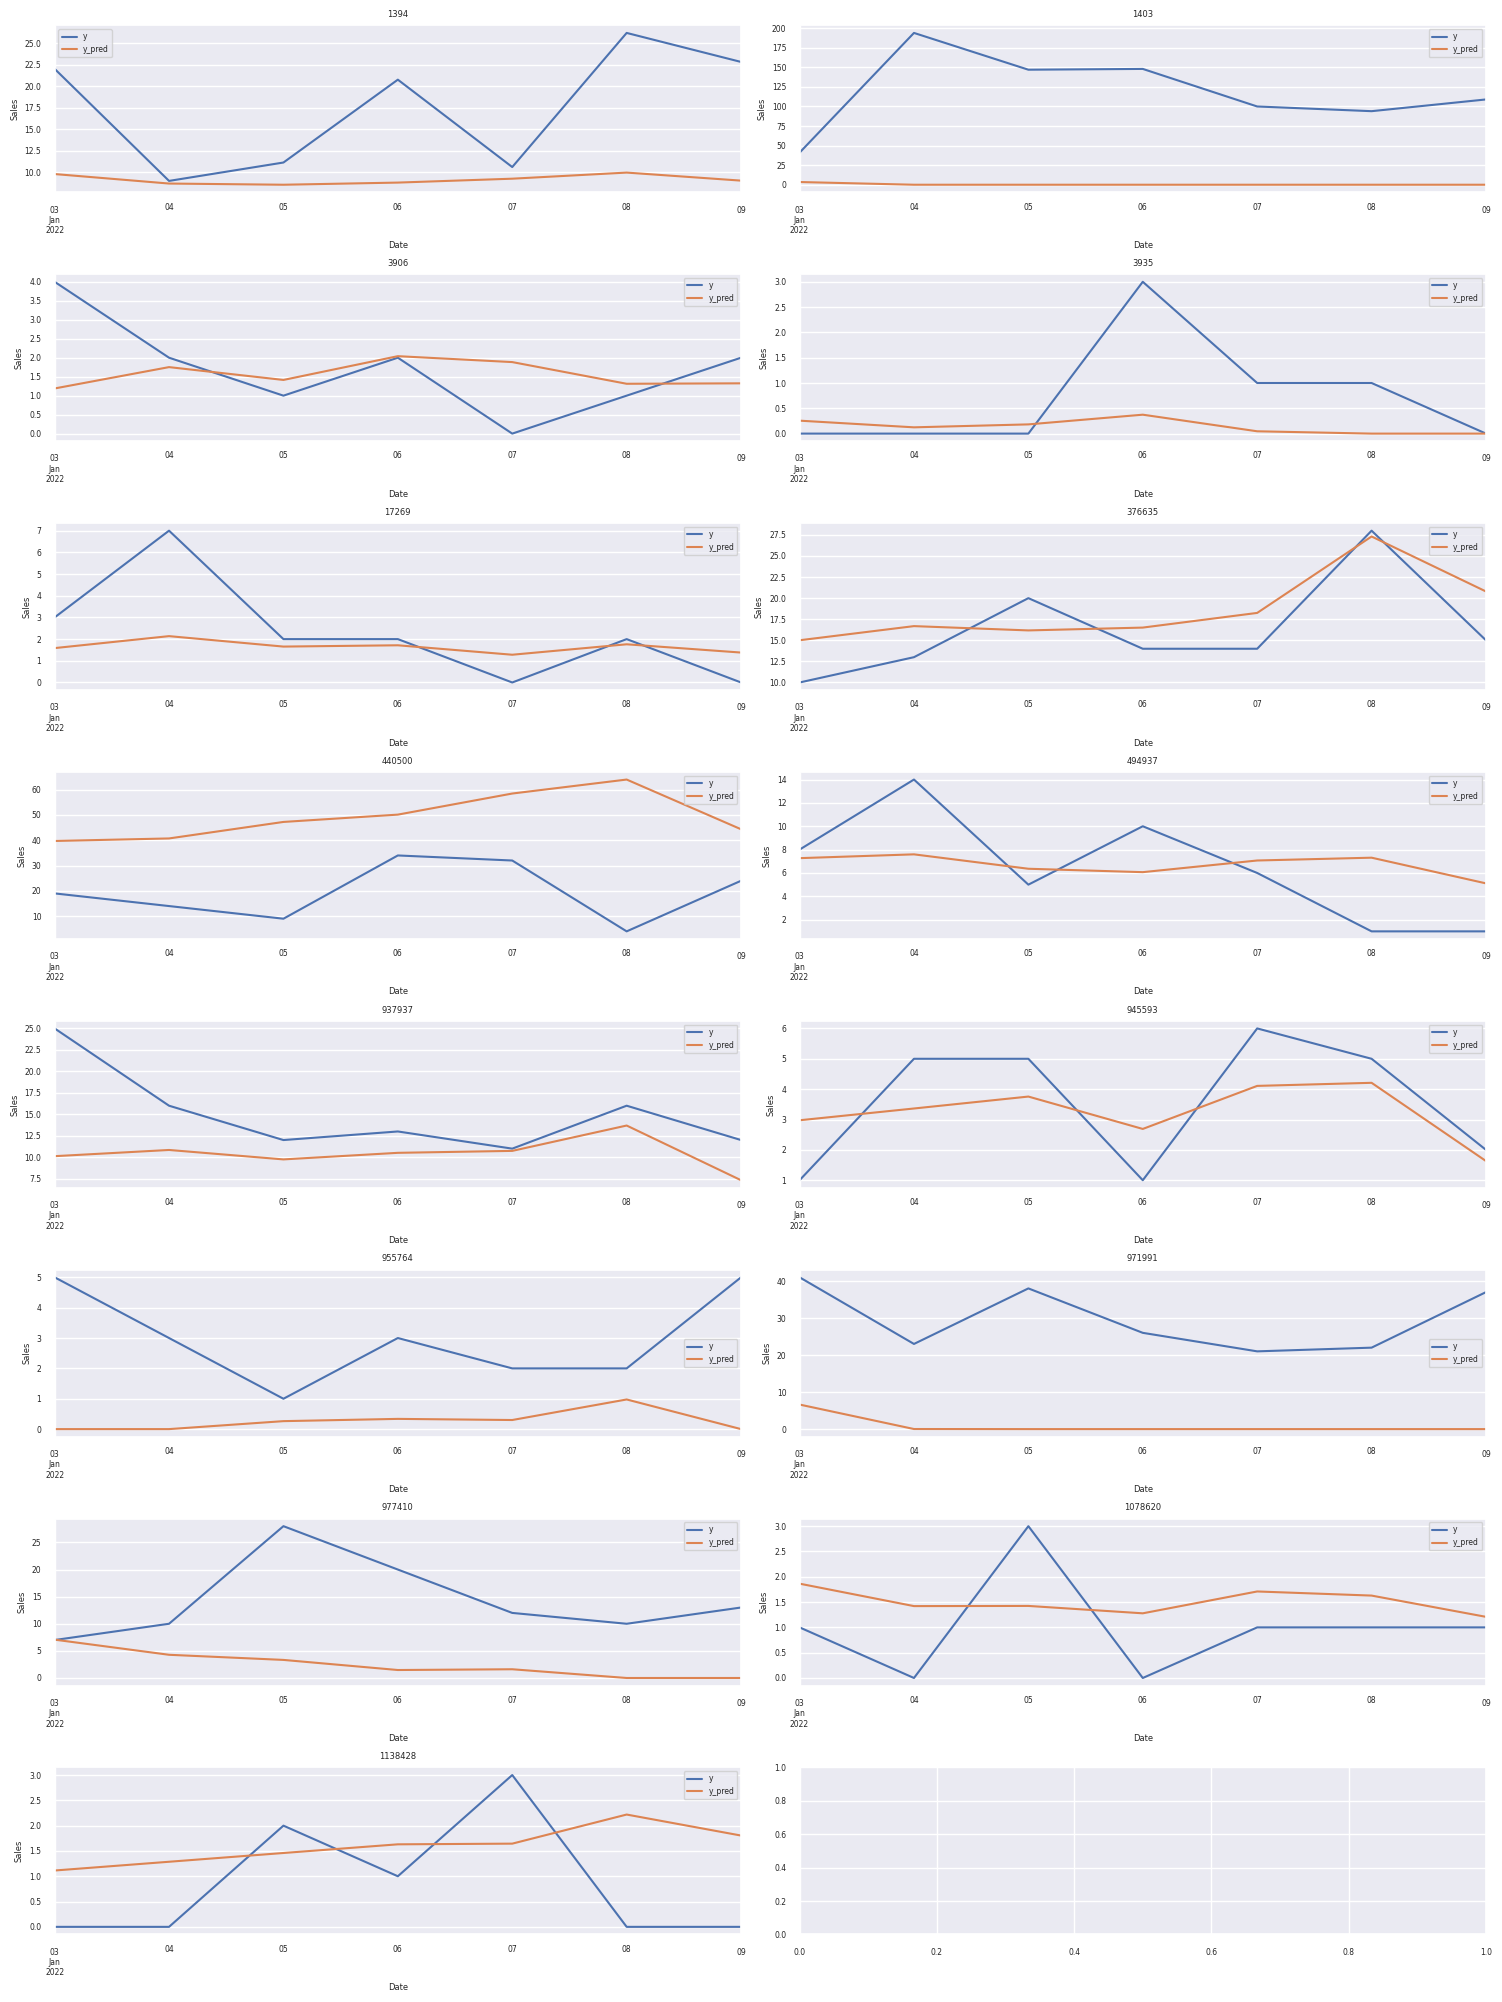

In [13]:
# Graficamos las predicciones vs el valor real para cada item
sns.set(font_scale=.5) 

fig, ax = plt.subplots(8,2, figsize=(15,20))
ax = ax.flatten()
for ax_ ,item_id in enumerate(sorted(df_predictions['item_id'].unique())):
    p_ = df_predictions.loc[(df_predictions['item_id'] == item_id)] 
    p_.plot(x='ds', y='y', ax=ax[ax_], label='y')
    p_.plot(x='ds', y='yhat', ax=ax[ax_], label='y_pred')
    ax[ax_].set_title(item_id)
    ax[ax_].legend()
    ax[ax_].set_xlabel('Date')
    ax[ax_].set_ylabel('Sales')
fig.tight_layout()
plt.show()

Las predicciones no parecen ser muy auspiciosas ya que para algunos items se estima menos de la cantidad de ventas y eso podría llegar a ser un problema y otros se estima muy por encima de los valores del datast de validación. Como primer acercamiento el resultados es regular pero podríamos probar agregar mayor infomración al modelo y volver a ajustarlo para lograr mejores resultados. Veamos ahora los errores de predicción.

In [14]:
pred_errors.sort_values(by='item_id')

,item_id,pred_mae,pred_rmse
13,1394,8.359293,10.395129
3,1403,152.628186,163.181266
5,3906,0.912232,1.322265
2,3935,0.790672,1.168218
8,17269,1.400663,2.050946
14,376635,3.678727,3.992894
11,440500,29.808621,32.911408
12,494937,3.416200,4.082823
0,937937,4.574949,6.397290
6,945593,1.371193,1.479728


Al analizar los errores de predicción para los diferentes items, podemos observar resultados muy diveresos. Por ejemplo el item_id 1403 tiene un error de predicción relativamente grande. El valor de pred_mae es 152, lo que indica una diferencia promedio de aproximadamente 152 unidades entre las predicciones y los valores reales. El pred_rmse es de 163, lo que indica una dispersión relativamente alta de los errores de predicción en relación con los valores reales. Esto sugiere que el modelo de pronóstico tiene dificultades para capturar los patrones y tendencias en los datos de este item en particular pero hay que tener en cuenta que los valores reales son altos con respecto a otras series.

Por otro lado, el item_id 1078620 tiene un error de predicción más pequeño. El valor de pred_mae es 0.954981, lo que indica una diferencia promedio de aproximadamente 0.95 unidades entre las predicciones y los valores reales. El pred_rmse es de 1.057177, lo que indica una dispersión relativamente baja de los errores de predicción en relación con los valores reales pero esta serie presenta valores de ventas más pequeños.

Al comparar los resultados entre este modelo y el AutoARIMA, se evidencia que en la mayoría de los ítems los errores son significativamente mayores. Esto nos indica que el modelo no está capturando de manera precisa la tendencia ni se está ajustando adecuadamente a la variabilidad de las ventas. Si bien desde el punto de vista computacional este modelo es más eficiente el ajuste no es muy bueno.

El modelo Prophet es una buena opción para realizar predicciones de ventas debido a sus características y funcionalidades específicas. Una de las principales ventajas de Prophet es su capacidad para manejar de manera efectiva datos con patrones de estacionalidad, tendencia y días festivos. El modelo incorpora de forma automática estas características en su estructura, lo que simplifica el proceso de modelado y pronóstico.
Sin embargo, este modelo también tiene algunas limitaciones. Por ejemplo, puede no ser adecuado para series temporales con patrones extremadamente irregulares o datos ruidosos.

Comparado con otros modelos populares como XGBoost o LSTM, Prophet se destaca por su enfoque específico en la modelización de series temporales con patrones estacionales y tendencias claras. Mientras que XGBoost es un modelo de aprendizaje automático potente y flexible que puede adaptarse a una amplia gama de problemas de pronóstico, LSTM es una red neuronal recurrente especializada en el procesamiento de secuencias de datos, incluyendo series temporales. Estos modelos, a diferencia de Prophet, pueden capturar relaciones más complejas y aprender patrones no lineales en los datos. Sin embargo, pueden requerir una mayor cantidad de datos y ajuste de hiperparámetros para obtener buenos resultados.

En el siguiente notebook ajustarmoes un modelo de regresión XGBoost para ver si logramos mejores resultados.

Referencias: 
- https://forecastegy.com/posts/multiple-time-series-forecasting-with-prophet-in-python/